## Generate Dummy dataset to test Machine learning model

**- Dataset distribution for skin impedance and frequency**


The distribution of the dataset is defined by generating random impedance values for each frequency within a uniform distribution that ranges from 10 to 200. Then, the mean and standard deviation of the impedances are calculated for the normal and abnormal skin cases.

Using these values, synthetic data and labels are generated for a total of 1000 samples. The normal data is generated from a normal distribution with the calculated mean and standard deviation for normal skin. The abnormal data is generated from a normal distribution with a mean of 30 more than the normal skin mean and a standard deviation of 1.5 times the normal skin standard deviation.

The resulting data and labels are shuffled using a random permutation of indices, and then saved as .npy files.

In [4]:
import numpy as np

# Set random seed for reproducibility
np.random.seed(42)

# Define frequency range and number of frequency values
freq_min = 1
freq_max = 100
num_freqs = 50

# Generate random impedance values for each frequency
freqs = np.linspace(freq_min, freq_max, num_freqs)
impedances = np.random.uniform(low=10, high=200, size=(num_freqs,))

# Define mean and standard deviation for normal and abnormal skin
normal_mean = impedances.mean()
normal_std = impedances.std()
abnormal_mean = impedances.mean() + 30
abnormal_std = impedances.std() * 1.5

# Generate synthetic data and labels
num_samples = 1000
num_abnormal = int(num_samples * 0.3)
num_normal = num_samples - num_abnormal

normal_data = np.random.normal(loc=normal_mean, scale=normal_std, size=(num_normal, num_freqs))
normal_labels = np.zeros((num_normal,))

abnormal_data = np.random.normal(loc=abnormal_mean, scale=abnormal_std, size=(num_abnormal, num_freqs))
abnormal_labels = np.ones((num_abnormal,))

data = np.vstack((normal_data, abnormal_data))
labels = np.concatenate((normal_labels, abnormal_labels))

# Shuffle data and labels
perm = np.random.permutation(num_samples)
data = data[perm]
labels = labels[perm]

# Save data and labels as .npy files
np.save('skin_data.npy', data)
np.save('skin_labels.npy', labels)


## Implement this code for generating .npy files for data ingestion in the model development
```
import numpy as np

# Load data and labels into numpy arrays
data = ...  # shape = (number of samples, number of impedance-frequency pairs)
labels = ...  # shape = (number of samples,)

# Save numpy arrays as .npy files
np.save('skin_data.npy', data)
np.save('skin_labels.npy', labels)
```


# SKICAD ENSEMBLE LEARNING BASED MODEL USING ALGORITHMS:


1. Random Forest
2. SIMCA
3. SVM
4. PCA
5. Neural Network







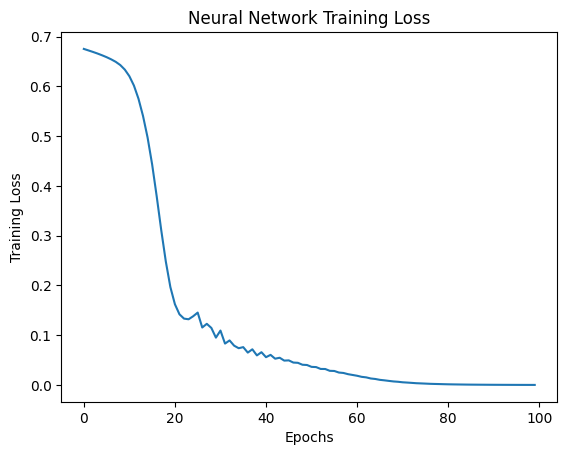

Neural network accuracy:  0.9433333333333334
Random Forest accuracy:  0.9466666666666667
SVM accuracy:  0.9633333333333334
Ensemble accuracy:  0.96


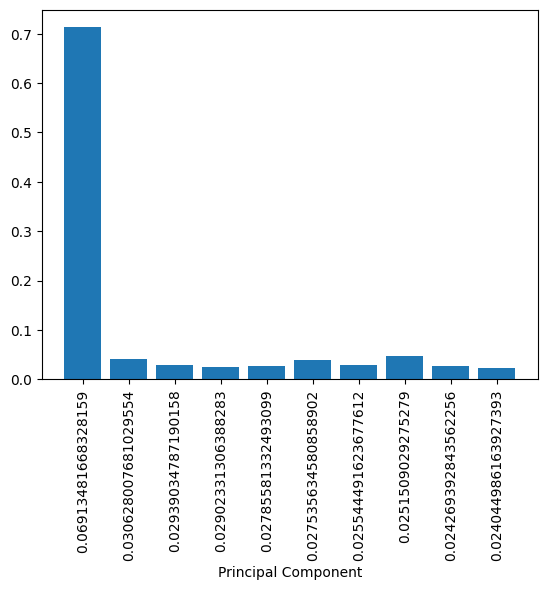

In [10]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
# Load data (impedance and frequency relation)
X = np.load('skin_data.npy')
y = np.load('skin_labels.npy')

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Normalize data using standard scaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=10)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# Convert data to PyTorch tensors
X_train = torch.Tensor(X_train)
X_test = torch.Tensor(X_test)
y_train = torch.LongTensor(y_train)
y_test = torch.LongTensor(y_test)

# Define deeper neural network
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(10, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc3 = nn.Linear(128, 256)
        self.fc4 = nn.Linear(256, 512)
        self.fc5 = nn.Linear(512, 256)
        self.fc6 = nn.Linear(256, 128)
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 32)
        self.fc9 = nn.Linear(32, 16)
        self.fc10 = nn.Linear(16, 2)

    def forward(self, x):
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = nn.functional.relu(self.fc3(x))
        x = nn.functional.relu(self.fc4(x))
        x = nn.functional.relu(self.fc5(x))
        x = nn.functional.relu(self.fc6(x))
        x = nn.functional.relu(self.fc7(x))
        x = nn.functional.relu(self.fc8(x))
        x = nn.functional.relu(self.fc9(x))
        x = self.fc10(x)
        return x

net = Net()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Train neural network
train_loss = []
for epoch in range(100):
    optimizer.zero_grad()
    outputs = net(X_train)
    loss = criterion(outputs, y_train)
    train_loss.append(loss.item())
    loss.backward()
    optimizer.step()

# Plot loss vs epochs for neural network
plt.plot(train_loss)
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.title('Neural Network Training Loss')
plt.show()

# Test neural network
with torch.no_grad():
    outputs = net(X_test)
    _, y_pred_nn = torch.max(outputs, dim=1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

# Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Plot feature importances for random forest
importances = rf.feature_importances_
plt.bar(range(10), importances)
plt.xticks(range(10), pca.explained_variance_ratio_, rotation=90)
plt.xlabel('Principal Component')

# SVM classifier
svm = SVC(kernel='rbf', C=1, gamma='scale', random_state=42)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

# Ensemble learning
y_pred_ensemble = np.zeros_like(y_test)
for i in range(len(y_test)):
    votes = [y_pred_nn[i], y_pred_rf[i], y_pred_svm[i]]
    y_pred_ensemble[i] = max(set(votes), key=votes.count)


# Evaluate accuracy
accuracy_nn = accuracy_score(y_test, y_pred_nn)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)

print("Neural network accuracy: ", accuracy_nn)
print("Random Forest accuracy: ", accuracy_rf)
print("SVM accuracy: ", accuracy_svm)
print("Ensemble accuracy: ", accuracy_ensemble)


### Confusion Matrix

Confusion matrix for the SVM classifier and plot it using a heatmap.The x-axis represents the predicted labels, while the y-axis represents the true labels. The values in the cells of the heatmap represent the number of instances that belong to that particular combination of true and predicted labels. The diagonal cells represent the correctly classified instances, while the off-diagonal cells represent the misclassified instances. The annotated numbers in the cells indicate the count of instances for that particular combination of true and predicted labels.

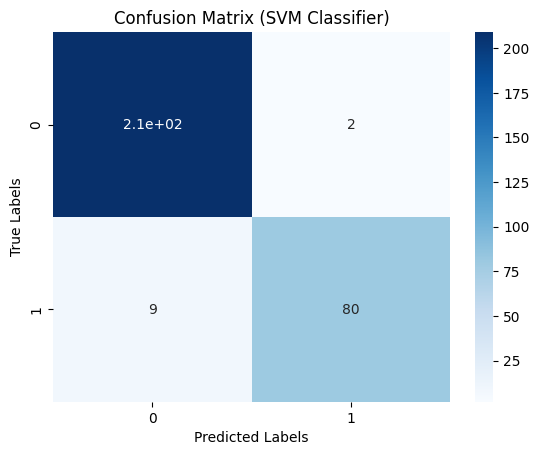

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Generate confusion matrix for SVM classifier
cm = confusion_matrix(y_test, y_pred_svm)

# Plot confusion matrix using heatmap
sns.heatmap(cm, annot=True, cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (SVM Classifier)')
plt.show()


### Description of Model implementation for future reference
The code performs the following tasks:
- Imports required libraries/modules such as numpy, sklearn, torch, and matplotlib.pyplot
- Loads skin data and labels from files using numpy.load()
- Splits the data into training and testing sets using train_test_split() from sklearn.model_selection
- Normalizes the data using StandardScaler() from sklearn.preprocessing
- Reduces the dimensionality of the data using Principal Component Analysis (PCA) from sklearn.decomposition
- Converts the data and labels to PyTorch tensors using torch.Tensor()
- Defines a deep neural network with 10 input features, 2 output classes, and 10 hidden layers using nn.Module from torch.nn
- Defines the loss function as Cross-Entropy Loss and the optimizer as Adam optimizer from torch.optim
- Trains the neural network for 100 epochs and records the training loss
- Plots the training loss vs the number of epochs using matplotlib.pyplot
- Tests the neural network on the testing data and calculates the accuracy score using accuracy_score() from sklearn.metrics
- Defines and trains a Random Forest classifier with 100 estimators from sklearn.ensemble
- Calculates the feature importances and plots them using matplotlib.pyplot
- Defines and trains a Support Vector Machine (SVM) classifier with the Radial Basis Function (RBF) kernel from sklearn.svm
- Combines the predictions from the neural network, Random Forest classifier, and SVM using majority voting to create an ensemble prediction
- Calculates the accuracy scores of the individual classifiers and the ensemble prediction using accuracy_score() from sklearn.metrics and prints them.




### Analyze the Skin Dataset

3D scatter plot of the skin data, where each point represents a sample and its position is determined by its values in the first three principal components. The color of each point represents its label (0 or 1), and the size of each point is fixed at 3


In [11]:
import plotly.graph_objects as go

# Reduce dimensionality using PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

# Create 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=X_reduced[:, 0],
    y=X_reduced[:, 1],
    z=X_reduced[:, 2],
    mode='markers',
    marker=dict(
        size=3,
        color=y,
        colorscale='Viridis',
        opacity=0.8
    )
)])

# Update layout
fig.update_layout(
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3'
    ),
    margin=dict(l=0, r=0, b=0, t=0),
    height=600
)

# Show plot
fig.show()

### Download the 3d model as gif

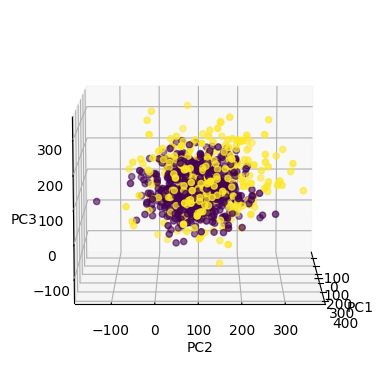

In [12]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
scatter = ax.scatter(X[:,0], X[:,1], X[:,2], c=y)

# Define the animation function
def animate(i):
    ax.view_init(elev=10., azim=i)
    return scatter,

# Create the animation and save as a GIF
ani = animation.FuncAnimation(fig, animate, frames=360, interval=50)
ani.save('3d_model.gif', writer='pillow')